In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

from IPython.display import clear_output

## 0. Инициализация констант для системы вода-лёд

In [2]:
rho_solid = 900  # solid density [kg/m^3]
rho_liquid = 1000  # liquid density [kg/m^3]

T_melting = 0  # meltin temperature [degree celcius]

# thermal conductivity as temperature function
def k(u, alpha):
    '''
    u - температура
    alpha - параметр масштаба
    '''
    K_solid = 2.22  # thermal conductivity in solis [W/m*k]
    K_liquid = 0.596  # thermal conductivity in liquid [W/m*k]

    # применяем сглаживание функцией tanh
    return 0.5*(K_solid + K_liquid) + np.tanh(alpha*u)*0.5*(K_liquid - K_solid)

def c(u, alpha):
    '''
    u - температура
    alpha - параметр масштаба
    '''
    c_solid = 42 # Дж/кг*K
    c_liquid = 21
    #melt_const = 3.33*10**3 # Дж/кг
    melt_const = 0 # Дж/кг

    # применяем сглаживание функцией tanh и его производной для разрыва 
    return 0.5*(c_solid + c_liquid) + np.tanh(alpha*u)*0.5*(c_liquid - c_solid) + 0.5*melt_const*alpha/np.cosh(alpha*u)**2

## 1. Реализация

In [3]:
# Метод прогонки

def thomas_algorithm(N, a, b, c, d):
    '''
    solves Ax = d, where A is a tridiagonal matrix consisting of vectors a, b, c
    N = number of equations
    a[] = subdiagonal
    b[] = main diagonal
    c[] = superdiagonal
    d[] = right part of equasion
    '''
    P, Q = np.zeros(N), np.zeros(N)
    P[0], Q[0] = c[0]/b[0], d[0]/b[0]
    
    for i in range(1, N):
        P[i] = c[i]/(b[i] - a[i]*P[i-1])
        Q[i] = (d[i] - a[i]*Q[i-1])/(b[i] - a[i]*P[i-1])
        
    ans = np.zeros(N)
    ans[N-1] = Q[N-1]
    for i in range(N-2, -1, -1):
        ans[i] = Q[i] - P[i]*ans[i+1]
    return ans

In [4]:
# Визуализатор

def show_progress(u, R, h, T):
    '''
    Визуализация процесса распространения волны.
    '''
    x = np.arange(0, R+h, h)
    # Стираем предыдущий вывод в тот момент, когда появится следующий
    clear_output(wait=True)

    # Строим новый график
    plt.figure(figsize=(6,12))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    theta = np.linspace(0, 2*np.pi, 100)
    R, Theta = np.meshgrid(x, theta) 
    u_polar = [u for i in range(100)]
    ax1.pcolormesh(R*np.cos(Theta), R*np.sin(Theta), u_polar)
    
    ax2.plot(x, u)
    ax2.set_xlabel('Пространственная координата')
    ax2.set_ylabel('Температура')
    
    plt.title(f'T = {T}')
    plt.grid()
    plt.show()

In [5]:
# Визуализатор

def show_progress(u, R, h, T):
    '''
    Визуализация процесса распространения волны.
    '''
    x = np.arange(0, R+h, h)
    # Стираем предыдущий вывод в тот момент, когда появится следующий
    clear_output(wait=True)

    # Строим новый график
    plt.figure(figsize=(6,6))
    plt.plot(x, u)
    plt.xlabel('Пространственная координата')
    plt.ylabel('Температура')
    
    plt.title(f'T = {T}')
    plt.grid()
    plt.show()

In [6]:
# Функция, задающая граничное условие на температуру

def f_border(t):
    '''
    t - время
    '''
    return -5

In [7]:
def implicit_scheme(u, c, k, R, T, h, courant, alpha):
    '''
    courant - число Куранта, в нелинейной задаче примем h^2/tau
    R - радиус цилиндра
    T - максимальное время, задаёт область во времени
    h - шаг по пространству
    u - начальное состояние
    c - функция теплоемкости от температуры
    k - функция теплопроводности от температуры
    alpha - параметр масштаба  сглаживания
    '''

    # зададим параметры метода
    tau = courant * h ** 2  # шаг по времени
    N = len(u)  # количество точек сетки по пространству
    
    show_progress(u, R, h, 0)
    for i in range(1, int(T / tau) + 1):
        # неявная схема с нелинейностью на нижнем слое
        '''
        a[] = subdiagonal
        b[] = main diagonal
        c[] = superdiagonal
        d[] = right part of equasion

        левое граничное условие (r=0) на производную
        правое граничное условие (r=R) на значение
        '''
        a_thomas = [0] + [-courant * (1 - 1 / (2*m)) * k((u[m-1]+u[m])/2, alpha) for m in range(1, N - 1)] + [0]
        b_thomas = [-1] + [c(u[m], alpha) + courant * ((1 - 1 / (2*m)) * k((u[m-1]+u[m])/2, alpha) + (1 + 1 / (2*m)) * k((u[m]+u[m+1])/2, alpha)) for m in
                    range(1, N - 1)] + [1]
        c_thomas = [1] + [-courant * (1 + 1 / (2*m)) * k((u[m]+u[m+1])/2, alpha) for m in range(1, N - 1)] + [0]
        d_thomas = [0] + list(u[1:-1]*c(u[1:-1], alpha)) + [f_border(i * tau)]
        u = thomas_algorithm(N, a_thomas, b_thomas, c_thomas, d_thomas)

        
        if i % 100 == 0:
            show_progress(u, R, h, i*tau)
        return u

In [8]:
u = np.arange(0, 1, 0.1)
u, (u[:-2] + u[1:-1])/2, (u[1:-1] + u[2:])/2

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75]),
 array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85]))

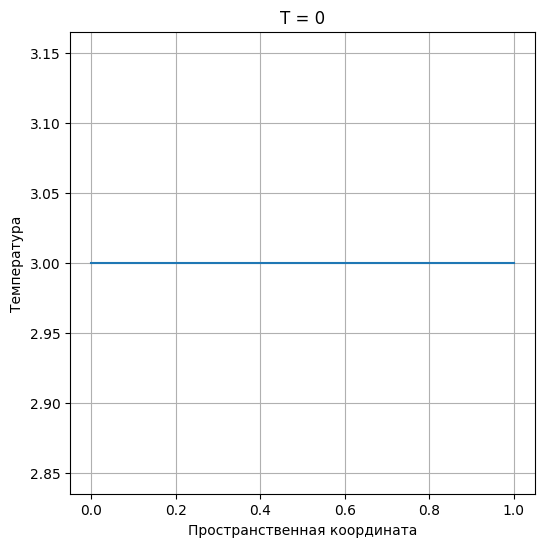

In [10]:

R = 1
T = 15
h = 0.01
courant = 10
alpha = 5

u0 = np.zeros(int(1/h)+1) + 3

u = implicit_scheme(u0, c, k, R, T, h, courant, alpha)